<a href="https://colab.research.google.com/github/MODAK27/COVID_flipr_hackathon/blob/master/files/3_Additional_ML_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 508 HW 1 Part 3: Regression and Classification Review


### Import Packages

We begin by importing the necessary libraries for this assignment:

- **Data Manipulation**: `numpy` and `pandas` for handling arrays and dataframes.
- **Visualization**: `matplotlib.pyplot` for creating plots.
- **Scikit-Learn (sklearn)**: A comprehensive machine learning library.
  - `model_selection`: For splitting data into training and testing sets.
  - `linear_model`: For Logistic Regression, Ridge, Lasso, and Linear Regression models.
  - `ensemble`: For Random Forest and Gradient Boosting classifiers.
  - `naive_bayes`: For the Gaussian Naive Bayes classifier.
  - `preprocessing`: For scaling features (`StandardScaler`).
  - `metrics`: For evaluating models (accuracy, MSE, R2 score, confusion matrix).
  - `datasets`: For loading sample datasets (Iris, Breast Cancer).
- **PyTorch**: `torch` for potential neural network components (though primarily sklearn is used in the exercises above).

We also set the random seed for reproducibility and configure plot styles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris, load_breast_cancer, make_classification
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.style.use(['ggplot'])
np.random.seed(42)

## 1. Quick Pandas Review

Pandas is a powerful library for data manipulation and analysis in Python. In this section, we'll review key concepts.

### **TODO 1:** Pandas Basics

Create a pandas DataFrame with the following data:
- Column 'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve']
- Column 'Age': [25, 30, 35, 28, 32]
- Column 'Salary': [50000, 60000, 75000, 55000, 70000]

**Detailed Steps:**
1. Use `pd.DataFrame()` with a dictionary to create the DataFrame
2. Print the entire DataFrame using `print(df)`
3. Calculate the mean salary using `df['Salary'].mean()`
4. Filter rows where Age > 28 using boolean indexing: `df[df['Age'] > 28]`
5. Add a new column 'Salary_per_Age' by dividing Salary by Age
6. Print the updated DataFrame to verify the new column was added

In [2]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve'],
    'Age': [25, 30, 35, 28, 32],
    'Salary': [50000, 60000, 75000, 55000, 70000]
})

print("DataFrame:")
print(df)

# Mean Salary
mean_salary = df['Salary'].mean()
print("\nMean Salary:", mean_salary)

# Filter rows where Age > 28
filtered_df = df[df['Age'] > 28]
print("\nFiltered Rows (Age > 28):")
print(filtered_df)

# Add new column
df['Salary_per_Age'] = df['Salary'] / df['Age']

print("\nUpdated DataFrame:")
print(df)


DataFrame:
      Name  Age  Salary
0    Alice   25   50000
1      Bob   30   60000
2  Charlie   35   75000
3    David   28   55000
4      Eve   32   70000

Mean Salary: 62000.0

Filtered Rows (Age > 28):
      Name  Age  Salary
1      Bob   30   60000
2  Charlie   35   75000
4      Eve   32   70000

Updated DataFrame:
      Name  Age  Salary  Salary_per_Age
0    Alice   25   50000     2000.000000
1      Bob   30   60000     2000.000000
2  Charlie   35   75000     2142.857143
3    David   28   55000     1964.285714
4      Eve   32   70000     2187.500000


## 2. Regression on Housing Prices

In this section, we'll use a simple housing dataset to perform regression analysis using pandas and sklearn.

In [3]:
# Generate realistic housing dataset (no download needed!)
# Based on California Housing characteristics but created locally

np.random.seed(42)
n_samples = 20640  # Same size as California Housing dataset

# Generate features with realistic ranges
MedInc = np.random.exponential(3.5, n_samples)  # Median income (in $10k)
HouseAge = np.random.uniform(1, 52, n_samples)  # House age (years)
AveRooms = np.random.gamma(4, 1.5, n_samples)  # Average rooms
AveBedrms = np.random.gamma(1.2, 0.5, n_samples)  # Average bedrooms
Population = np.random.exponential(1000, n_samples)  # Block population
AveOccup = np.random.gamma(3, 1, n_samples)  # Average occupancy
Latitude = np.random.uniform(32.5, 42, n_samples)  # California latitude
Longitude = np.random.uniform(-124.5, -114, n_samples)  # California longitude

# Generate realistic price based on features (in $100k)
# Price influenced by income, house age (negative), rooms, location
Price = (
    0.45 * MedInc +  # Income is main factor
    -0.01 * HouseAge +  # Older houses worth less
    0.05 * AveRooms +  # More rooms = higher price
    -0.3 * np.abs(Latitude - 37.5) +  # Central California more expensive
    -0.2 * np.abs(Longitude + 119) +  # Coastal areas more expensive
    np.random.normal(0, 0.5, n_samples)  # Add noise
)
Price = np.clip(Price, 0.5, 5.0)  # Realistic price range

# Create DataFrame
housing_data = pd.DataFrame({
    'MedInc': MedInc,
    'HouseAge': HouseAge,
    'AveRooms': AveRooms,
    'AveBedrms': AveBedrms,
    'Population': Population,
    'AveOccup': AveOccup,
    'Latitude': Latitude,
    'Longitude': Longitude,
    'Price': Price
})

print("🏠 Housing Dataset (Realistic California-style data - No download required!)")
print(housing_data.head())
print(f"\nDataset shape: {housing_data.shape}")
print(f"\nFeature descriptions:")
print(f"  MedInc     - Median income in block group (in $10,000s)")
print(f"  HouseAge   - Median house age in block group")
print(f"  AveRooms   - Average number of rooms per household")
print(f"  AveBedrms  - Average number of bedrooms per household")
print(f"  Population - Block group population")
print(f"  AveOccup   - Average household occupancy")
print(f"  Latitude   - Latitude of block group")
print(f"  Longitude  - Longitude of block group")
print(f"  Price      - Median house value in block group (in $100,000s)")
print(f"\nStatistics:\n{housing_data.describe()}")

🏠 Housing Dataset (Realistic California-style data - No download required!)
      MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
0   1.642438  18.043376  5.996668   2.747711   485.885759  3.963741   
1  10.535425  18.898620  7.703154   0.235783   210.295710  0.346653   
2   4.608610   3.631730  8.535462   0.728460   335.727193  4.971332   
3   3.195299   7.073811  8.136975   0.526241  1238.316253  2.000612   
4   0.593687  10.851426  6.226264   0.506739   822.991719  4.506845   

    Latitude   Longitude     Price  
0  39.814432 -122.840697  0.500000  
1  40.214854 -119.603258  3.084443  
2  35.480570 -124.339356  1.521066  
3  40.835820 -114.915344  0.500000  
4  34.271200 -118.141597  0.500000  

Dataset shape: (20640, 9)

Feature descriptions:
  MedInc     - Median income in block group (in $10,000s)
  HouseAge   - Median house age in block group
  AveRooms   - Average number of rooms per household
  AveBedrms  - Average number of bedrooms per household
  Populatio

### **TODO 2:** Implement Housing Price Regression

**Detailed Steps:**
1. **Extract features and target:**
   - Select three features: 'MedInc', 'HouseAge', 'AveRooms' from housing_data
   - Extract the 'Price' column as the target variable
   - Convert both to numpy arrays using `.values`

2. **Split the data:**
   - Use `train_test_split()` with test_size=0.2 and random_state=42
   - This creates X_train, X_test, y_train, y_test

3. **Train the model:**
   - Create a `LinearRegression()` instance
   - Fit it using `model.fit(X_train, y_train)`

4. **Make predictions:**
   - Predict on training set: `y_train_pred = model.predict(X_train)`
   - Predict on test set: `y_test_pred = model.predict(X_test)`

5. **Calculate metrics:**
   - Use `mean_squared_error()` for MSE on both sets
   - Use `r2_score()` for R² on both sets
   - Print all metrics

6. **Visualize results:**
   - Create a scatter plot of actual vs predicted prices
   - Add a diagonal line representing perfect predictions
   - Label axes and add a title

=== Housing Price Regression Metrics ===
Train MSE: 0.2415
Test  MSE: 0.2499
Train R^2: 0.7890
Test  R^2: 0.7823


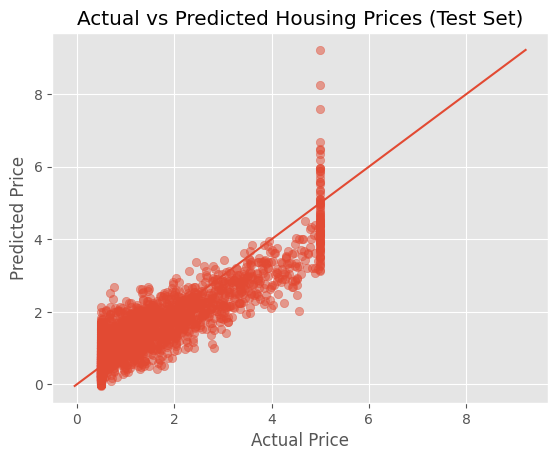

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extract features and target
X_housing = housing_data[['MedInc', 'HouseAge', 'AveRooms']].values
y_housing = housing_data['Price'].values

# 1. Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# 2. Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 4. Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=== Housing Price Regression Metrics ===")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test  MSE: {test_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test  R^2: {test_r2:.4f}")

# 5. Visualize results (Actual vs Predicted on Test Set)
plt.figure()
plt.scatter(y_test, y_test_pred, alpha=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])  # perfect prediction line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Housing Prices (Test Set)")
plt.show()


## 3. Binary Classification with Multiple Loss Functions

This section demonstrates different loss functions used in binary classification: MSE, 0/1 loss, Hinge loss, and Binary Cross Entropy.

In [27]:
# Generate synthetic binary classification dataset
X, y = make_classification(n_samples=300, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1,
                           random_state=42)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_, X_test_, y_train_, y_test_ = X_train, X_test, y_train, y_test #to be used in q8
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set size: 240
Test set size: 60
Class distribution in training: [121 119]


### **TODO 3:** Implement Loss Functions and Compare

**Detailed Steps:**
1. **Implement four loss functions:**
   - `mse_loss(y_true, y_pred)`: Mean Squared Error
   - `zero_one_loss(y_true, y_pred)`: Misclassification rate
   - `hinge_loss(y_true, y_pred)`: SVM-style hinge loss (convert labels to {-1, 1})
   - `binary_cross_entropy_loss(y_true, y_pred)`: Log loss for classification

2. **Train a logistic regression model:**
   - Create `LogisticRegression(max_iter=1000)` instance
   - Fit on X_train, y_train

3. **Get different prediction formats:**
   - `decision_function()`: Get raw logits for MSE and Hinge loss
   - `predict_proba()`: Get probabilities for Binary Cross-Entropy
   - `predict()`: Get binary labels for 0/1 loss

4. **Calculate all four losses on test set:**
   - Apply each loss function with appropriate prediction format
   - Print all four loss values

5. **Additional metrics:**
   - Calculate R² score
   - Calculate accuracy (1 - zero_one_loss)

In [28]:
import numpy as np

def mse_loss(y_true, y_pred):
    """
    Mean Squared Error Loss
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean((y_true - y_pred) ** 2))

def zero_one_loss(y_true, y_pred):
    """
    0/1 Loss (misclassification rate)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true != y_pred))

def hinge_loss(y_true, y_pred):
    """
    Hinge Loss (binary). Converts y_true in {0,1} -> {-1,+1}.
    Uses raw scores/logits in y_pred (decision_function output).
    L = mean(max(0, 1 - y * score))
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    y_bin = np.where(y_true == 1, 1, -1)  # {0,1} -> {-1, +1}
    return float(np.mean(np.maximum(0.0, 1.0 - y_bin * y_pred)))

def binary_cross_entropy_loss(y_true, y_pred):
    """
    Binary Cross Entropy Loss (log loss).
    Expects probabilities y_pred in [0,1] for class 1.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return float(-np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))

print("Loss functions implemented successfully!")


Loss functions implemented successfully!


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get predictions as logits, probabilities, and labels (test set)
logits = log_reg.decision_function(X_test)          # raw scores for MSE + hinge
probs = log_reg.predict_proba(X_test)[:, 1]         # P(y=1) for BCE
preds = log_reg.predict(X_test)                     # labels for 0/1

# Calculate all four losses (test set)
mse = mse_loss(y_test, logits)                      # MSE on logits
zero_one = zero_one_loss(y_test, preds)             # misclassification rate
hinge = hinge_loss(y_test, logits)                  # hinge on logits
bce = binary_cross_entropy_loss(y_test, probs)      # BCE on probabilities

# Additional metrics
r2 = r2_score(y_test, probs)                        # R^2 on probabilities (continuous)
accuracy = 1 - zero_one

# Print results
print("=== Logistic Regression Loss Comparison (Test Set) ===")
print(f"MSE (on logits):                 {mse:.6f}")
print(f"0/1 Loss (misclassification):    {zero_one:.6f}")
print(f"Hinge Loss (on logits):          {hinge:.6f}")
print(f"Binary Cross Entropy (on prob):  {bce:.6f}")
print(f"R^2 (on prob):                   {r2:.6f}")
print(f"Accuracy:                        {accuracy:.6f}")


=== Logistic Regression Loss Comparison (Test Set) ===
MSE (on logits):                 11.011487
0/1 Loss (misclassification):    0.050000
Hinge Loss (on logits):          0.142795
Binary Cross Entropy (on prob):  0.168170
R^2 (on prob):                   0.823042
Accuracy:                        0.950000


## 4. Naive Bayes Classification

Naive Bayes is a simple probabilistic classifier based on Bayes' theorem with strong independence assumptions.

### **TODO 4:** Naive Bayes on Iris Dataset

**Detailed Steps:**
1. **Load the Iris dataset:**
   - Use `load_iris()` to get the dataset
   - Extract features (X) and labels (y)

2. **Split the data:**
   - Use `train_test_split()` with test_size=0.2, random_state=42
   - Creates X_train, X_test, y_train, y_test

3. **Train Gaussian Naive Bayes:**
   - Create `GaussianNB()` instance
   - Fit on training data

4. **Evaluate the model:**
   - Calculate training accuracy using `.score()`
   - Calculate test accuracy using `.score()`
   - Print both accuracies

5. **Print confusion matrix:**
   - Use `confusion_matrix()` on test predictions
   - This shows which classes are confused with each other

6. **Print classification report:**
   - Use `classification_report()` with target names
   - Shows precision, recall, F1-score for each class

7. **Show probabilities and class selection:**
   - Select a few test samples (e.g., first 5)
   - Use `predict_proba()` to get the probability for each class
   - Print the probabilities and the actual selected class (highest probability) to demonstrate how Naive Bayes makes decisions.

8. **Answer the question:**
   - Explain why Naive Bayes is called "naive"
   - Discuss the independence assumption

In [11]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

iris = load_iris()
X, y = iris.data, iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train, y_train)
test_acc = nb.score(X_test, y_test)
print("=== Gaussian Naive Bayes on Iris ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")

y_test_pred = nb.predict(X_test)

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

k = 5
X_sel = X_test[:k]
y_sel = y_test[:k]

probs = nb.predict_proba(X_sel)
preds = np.argmax(probs, axis=1)

print(f"\nFirst {k} test samples: predicted probabilities + chosen class")
for i in range(k):
    prob_str = ", ".join([f"{target_names[c]}={probs[i, c]:.3f}" for c in range(len(target_names))])
    print(f"Sample {i}: [{prob_str}]  -> Pred: {target_names[preds[i]]} | True: {target_names[y_sel[i]]}")




=== Gaussian Naive Bayes on Iris ===
Train Accuracy: 0.9583
Test  Accuracy: 0.9667

Confusion Matrix (Test):
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]

Classification Report (Test):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


First 5 test samples: predicted probabilities + chosen class
Sample 0: [setosa=1.000, versicolor=0.000, virginica=0.000]  -> Pred: setosa | True: setosa
Sample 1: [setosa=0.000, versicolor=0.088, virginica=0.912]  -> Pred: virginica | True: virginica
Sample 2: [setosa=0.000, versicolor=1.000, virginica=0.000]  -> Pred: versicolor | True: versicolor
Sample 3: [setosa=0.000, versicolor=1.000, virginica=0.000]  -> Pred: versicolor | True: v

8 :) It is called 'naive' because it assumes all features are conditionally independent given the class label.That is, P(x1, x2, ..., xd | y) = Π_j P(xj | y). This assumption is often false in real data, but the model still works surprisingly well in many cases.

## 5. Regularization: L1 and L2

Regularization prevents overfitting by adding a penalty term to the loss function. L1 (Lasso) and L2 (Ridge) are two common approaches.

In [21]:
# Generate dataset with many features (high dimensionality)
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)
X_cancer = StandardScaler().fit_transform(X_cancer)

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = \
    train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

print(f"Feature dimension: {X_cancer.shape[1]}")
print(f"Training samples: {X_train_cancer.shape[0]}")

Feature dimension: 30
Training samples: 455


### **TODO 5:** Compare L1 and L2 Regularization

**Detailed Steps:**
1. **Set up the experiment:**
   - Define alpha values: [0.001, 0.01, 0.1, 1, 10]
   - Initialize empty lists to store results for both methods

2. **Train models with different alphas:**
   - Loop through each alpha value
   - For Ridge (L2): Create `Ridge(alpha=alpha)`, fit, record train/test scores
   - For Ridge: Count non-zero coefficients using `np.sum(abs(coef_) > 1e-5)` (Ridge coefs rarely hit exactly zero)
   - For Ridge: Record min and max coefficient values
   - For Lasso (L1): Create `Lasso(alpha=alpha)`, fit, record train/test scores
   - For Lasso: Count non-zero coefficients using `np.sum(coef_ != 0)`
   - For Lasso: Record min and max coefficient values

3. **Visualize results:**
   - Create 2 subplots (1 row, 2 columns)
   - Plot 1: Ridge train/test accuracy vs alpha (log scale)
   - Plot 2: Lasso train/test accuracy vs alpha (log scale)
   - Add labels, titles, legends, and grid

4. **Print comparison table:**
   - Create a formatted table showing alpha, Ridge scores, Lasso scores, non-zero coefficients, and min/max coefficient values for *both* Ridge and Lasso.
   - Use proper column alignment

5. **Answer the question:**
   - Explain the difference between L1 and L2 regularization
   - Discuss when to use each method
   - Explain feature selection property of Lasso

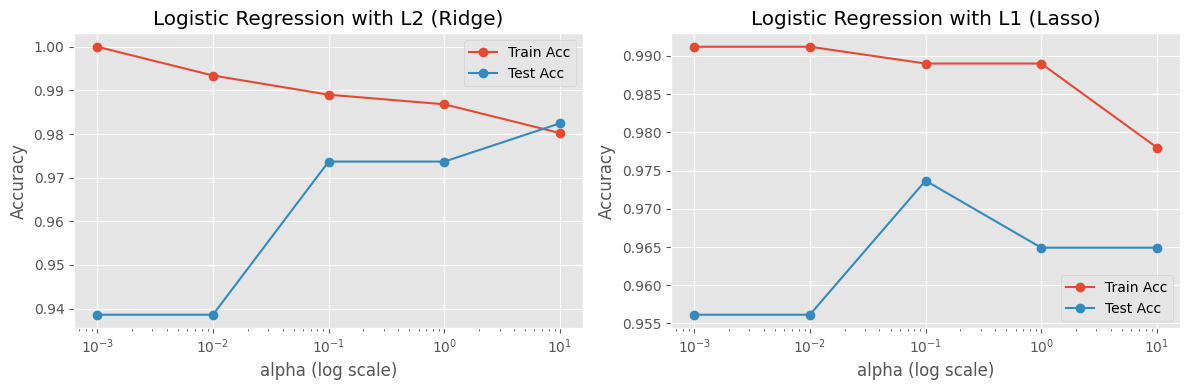

   alpha |   L2_tr   L2_te  L2_nz     L2_min     L2_max |   L1_tr   L1_te  L1_nz     L1_min     L1_max
--------------------------------------------------------------------------------------------------------------
   0.001 |  1.0000  0.9386     30   -27.8793    31.1359 |  0.9912  0.9561     30    -7.2122     6.8470
    0.01 |  0.9934  0.9386     30    -9.5251     9.9108 |  0.9912  0.9561     30    -6.9842     6.6098
     0.1 |  0.9890  0.9737     30    -3.4930     2.7149 |  0.9890  0.9737     22    -4.9980     4.2733
       1 |  0.9868  0.9737     30    -1.3575     0.6691 |  0.9890  0.9649     15    -2.3934     0.8111
      10 |  0.9802  0.9825     30    -0.6008     0.2617 |  0.9780  0.9649      8    -1.9600     0.0000


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

alphas = [0.001, 0.01, 0.1, 1, 10]

l2_train_acc, l2_test_acc = [], []
l1_train_acc, l1_test_acc = [], []

l2_nonzero, l1_nonzero = [], []
l2_mincoef, l2_maxcoef = [], []
l1_mincoef, l1_maxcoef = [], []

for alpha in alphas:
    C = 1.0 / alpha  # sklearn uses inverse regularization strength

    # L2 (Ridge-style) Logistic Regression
    l2 = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=10000)
    l2.fit(X_train_cancer, y_train_cancer)

    l2_train_acc.append(l2.score(X_train_cancer, y_train_cancer))
    l2_test_acc.append(l2.score(X_test_cancer, y_test_cancer))

    coef_l2 = l2.coef_.ravel()
    l2_nonzero.append(int(np.sum(np.abs(coef_l2) > 1e-5)))
    l2_mincoef.append(float(coef_l2.min()))
    l2_maxcoef.append(float(coef_l2.max()))

    # L1 (Lasso-style) Logistic Regression
    l1 = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=10000)
    l1.fit(X_train_cancer, y_train_cancer)

    l1_train_acc.append(l1.score(X_train_cancer, y_train_cancer))
    l1_test_acc.append(l1.score(X_test_cancer, y_test_cancer))

    coef_l1 = l1.coef_.ravel()
    l1_nonzero.append(int(np.sum(coef_l1 != 0)))
    l1_mincoef.append(float(coef_l1.min()))
    l1_maxcoef.append(float(coef_l1.max()))

# ---- Plots ----
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(alphas, l2_train_acc, marker='o', label="Train Acc")
plt.plot(alphas, l2_test_acc, marker='o', label="Test Acc")
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression with L2 (Ridge)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alphas, l1_train_acc, marker='o', label="Train Acc")
plt.plot(alphas, l1_test_acc, marker='o', label="Test Acc")
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression with L1 (Lasso)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---- Table ----
print(f"{'alpha':>8} | {'L2_tr':>7} {'L2_te':>7} {'L2_nz':>6} {'L2_min':>10} {'L2_max':>10} | "
      f"{'L1_tr':>7} {'L1_te':>7} {'L1_nz':>6} {'L1_min':>10} {'L1_max':>10}")
print("-" * 110)

for i, a in enumerate(alphas):
    print(f"{a:8.3g} | "
          f"{l2_train_acc[i]:7.4f} {l2_test_acc[i]:7.4f} {l2_nonzero[i]:6d} {l2_mincoef[i]:10.4f} {l2_maxcoef[i]:10.4f} | "
          f"{l1_train_acc[i]:7.4f} {l1_test_acc[i]:7.4f} {l1_nonzero[i]:6d} {l1_mincoef[i]:10.4f} {l1_maxcoef[i]:10.4f}")


L2 (Ridge) regularization adds alpha * sum(w^2). It shrinks all weights smoothly and rarely makes them exactly 0.
Use L2 when many features matter and you want stability (good with correlated features).

L1 (Lasso) regularization adds alpha * sum(|w|). It can push some weights exactly to 0, performing feature selection.
Use L1 when you suspect only a subset of features are important and you want a sparse, interpretable model.


## 6. Gradient Boosting

Gradient Boosting builds an ensemble of decision trees sequentially, where each new tree corrects the errors made by previous trees.

### What You'll Do in This Section:

In this exercise, you'll explore how **Gradient Boosting** creates powerful predictive models by combining many "weak learners" (simple decision trees) into a strong ensemble. Unlike Random Forest which builds trees independently in parallel, Gradient Boosting builds trees one at a time, with each new tree focusing on fixing the mistakes of the previous trees.

**High-Level Goal:**
- Train Gradient Boosting models with different numbers of trees (10, 50, 100, 200)
- Observe how adding more trees improves performance
- Analyze which features the model considers most important
- Compare the sequential boosting approach with Random Forest's parallel approach

**Key Concepts You'll Learn:**
1. **Sequential Learning**: How each tree learns from the residual errors of previous trees
2. **Model Complexity**: How the number of estimators affects accuracy and overfitting
3. **Feature Importance**: Which features contribute most to predictions
4. **Boosting vs Bagging**: The fundamental difference between Gradient Boosting (sequential) and Random Forest (parallel)

You'll visualize learning curves to see how performance improves with more trees, and examine feature importances to understand what drives the model's decisions.

### **TODO 6:** Gradient Boosting Classifier

**Detailed Steps:**
1. **Set up the experiment:**
   - Define n_estimators values: [10, 50, 100, 200]
   - Initialize lists to store train/test accuracies

2. **Train models with different n_estimators:**
   - Loop through each n_estimators value
   - Create `GradientBoostingClassifier(n_estimators=n_est, random_state=42)`
   - Fit on training data
   - Record both training and test accuracies
   - Keep the final model for feature importance

3. **Create visualizations:**
   - Plot 1: Learning curves showing train/test accuracy vs n_estimators
   - Plot 2: Top 10 feature importances (horizontal bar chart)
   - Use proper labels, titles, and legends

4. **Print results table:**
   - Show n_estimators, train accuracy, test accuracy, and gap
   - Format as a clean table

5. **Answer the question:**
   - Explain how Gradient Boosting differs from Random Forest
   - Discuss sequential vs parallel tree building
   - Explain the concept of boosting and error correction

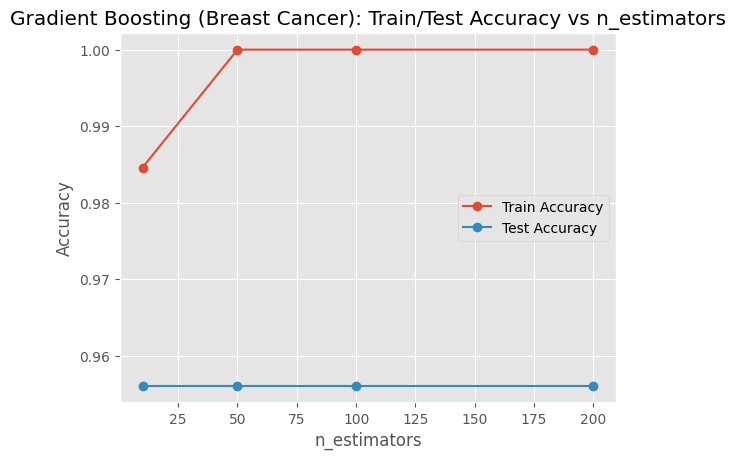

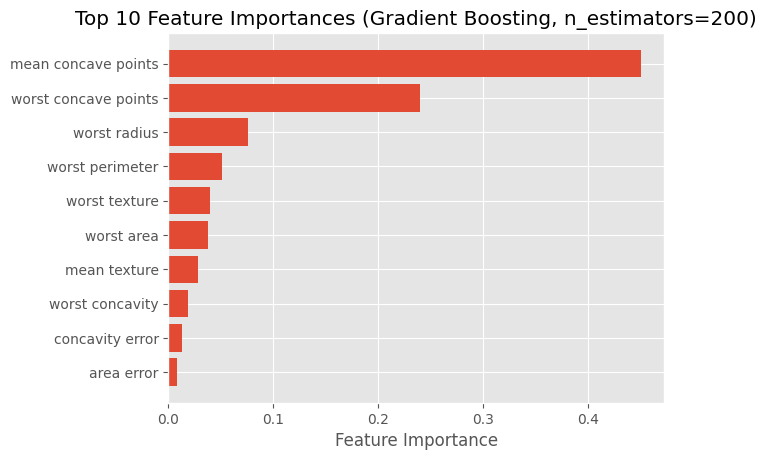

n_estimators | train_acc | test_acc |      gap
----------------------------------------------
          10 |    0.9846 |   0.9561 |   0.0285
          50 |    1.0000 |   0.9561 |   0.0439
         100 |    1.0000 |   0.9561 |   0.0439
         200 |    1.0000 |   0.9561 |   0.0439


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

# If feature names are needed (for importance plot)
cancer = load_breast_cancer()
feature_names = cancer.feature_names

n_estimators_list = [10, 50, 100, 200]
train_accs, test_accs = [], []
final_model = None

# Train gradient boosting models with different n_estimators
for n_est in n_estimators_list:
    model = GradientBoostingClassifier(n_estimators=n_est, random_state=42)
    model.fit(X_train_cancer, y_train_cancer)

    train_pred = model.predict(X_train_cancer)
    test_pred = model.predict(X_test_cancer)

    train_acc = accuracy_score(y_train_cancer, train_pred)
    test_acc = accuracy_score(y_test_cancer, test_pred)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    final_model = model  # keep last model for feature importance

# Plot learning curves
plt.figure()
plt.plot(n_estimators_list, train_accs, marker='o', label="Train Accuracy")
plt.plot(n_estimators_list, test_accs, marker='o', label="Test Accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting (Breast Cancer): Train/Test Accuracy vs n_estimators")
plt.grid(True)
plt.legend()
plt.show()

# Plot feature importance (Top 10)
importances = final_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_k = 10
top_idx = sorted_idx[:top_k]

plt.figure()
plt.barh(range(top_k), importances[top_idx][::-1])
plt.yticks(range(top_k), np.array(feature_names)[top_idx][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_k} Feature Importances (Gradient Boosting, n_estimators={n_estimators_list[-1]})")
plt.grid(True)
plt.show()

# Print results table
print(f"{'n_estimators':>12} | {'train_acc':>9} | {'test_acc':>8} | {'gap':>8}")
print("-" * 46)
for n_est, tr, te in zip(n_estimators_list, train_accs, test_accs):
    print(f"{n_est:12d} | {tr:9.4f} | {te:8.4f} | {tr - te:8.4f}")



# Qurstion:
How does Gradient Boosting differ from Random Forest?
Random Forest: builds many trees independently (in parallel) using bagging + feature subsampling, then averages/votes.

Gradient Boosting: builds trees sequentially; each new tree is trained to correct the errors (residuals) of the current ensemble.

Boosting = additive model: F_{t+1}(x) = F_t(x) + eta * h_t(x), where h_t focuses on mistakes made so far.

Practically: boosting often achieves higher accuracy with careful tuning, but can overfit if too many trees or too deep trees.


## 7. Random Forest

Random Forest builds multiple decision trees in parallel using random subsets of features and samples, then aggregates their predictions.

### **TODO 7:** Random Forest Classifier

**Detailed Steps:**
1. **Set up the experiment:**
   - Use same n_estimators values as TODO 6: [10, 50, 100, 200]
   - Initialize lists to store train/test accuracies

2. **Train Random Forest models:**
   - Loop through each n_estimators value
   - Create `RandomForestClassifier(n_estimators=n_est, random_state=42)`
   - Fit on training data
   - Record both training and test accuracies
   - Keep the final model for feature importance

3. **Create comparison visualizations:**
   - Plot 1: Compare RF and GB learning curves on same plot
     - Plot RF train/test accuracy
     - Plot GB train/test accuracy (from TODO 6)
     - Use different line styles to distinguish
   - Plot 2: Compare feature importances side-by-side
     - Create bar chart comparing RF and GB for top 10 features

4. **Print results:**
   - Table showing RF n_estimators, train/test accuracy, and gap
   - Final comparison: RF vs GB test accuracy

5. **Answer the question:**
   - Explain why Random Forest uses random feature subsets
   - Discuss decorrelation of trees
   - Explain variance reduction through averaging

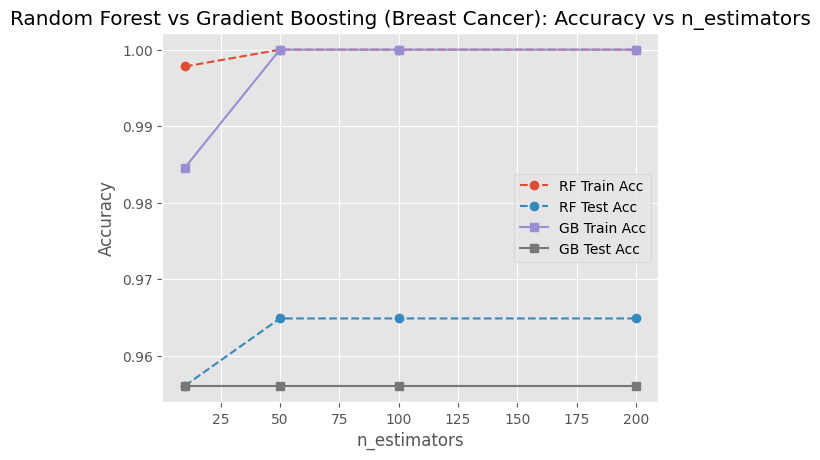

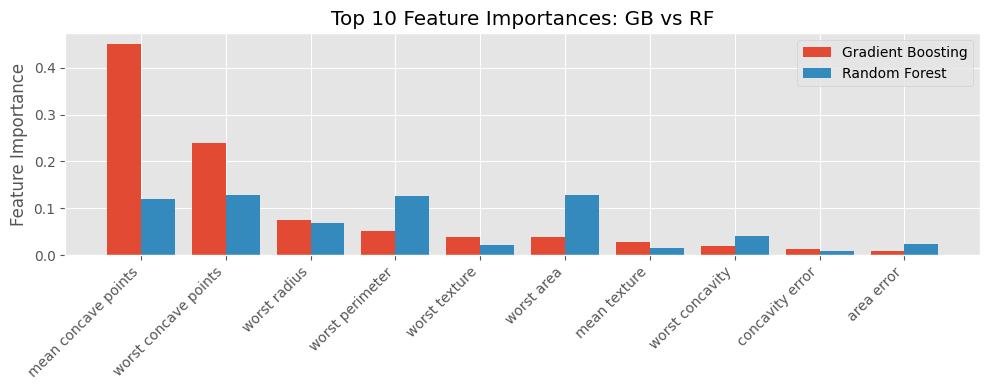

n_estimators | train_acc | test_acc |      gap
----------------------------------------------
          10 |    0.9978 |   0.9561 |   0.0417
          50 |    1.0000 |   0.9649 |   0.0351
         100 |    1.0000 |   0.9649 |   0.0351
         200 |    1.0000 |   0.9649 |   0.0351

Final Comparison (n_estimators=200):
GB Test Accuracy: 0.9561
RF Test Accuracy: 0.9649


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assumes you already ran TODO 6 and have:
# - n_estimators_list
# - train_accs, test_accs (Gradient Boosting accuracies)
# - final_model (Gradient Boosting final model)
# - feature_names (breast cancer feature names)

rf_train_accs, rf_test_accs = [], []
rf_final_model = None

# Train random forest models
for n_est in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf.fit(X_train_cancer, y_train_cancer)

    train_pred = rf.predict(X_train_cancer)
    test_pred = rf.predict(X_test_cancer)

    tr_acc = accuracy_score(y_train_cancer, train_pred)
    te_acc = accuracy_score(y_test_cancer, test_pred)

    rf_train_accs.append(tr_acc)
    rf_test_accs.append(te_acc)

    rf_final_model = rf  # keep last model for feature importance

# Plot 1: Compare RF and GB learning curves
plt.figure()
plt.plot(n_estimators_list, rf_train_accs, marker='o', linestyle='--', label="RF Train Acc")
plt.plot(n_estimators_list, rf_test_accs, marker='o', linestyle='--', label="RF Test Acc")
plt.plot(n_estimators_list, train_accs, marker='s', linestyle='-', label="GB Train Acc")
plt.plot(n_estimators_list, test_accs, marker='s', linestyle='-', label="GB Test Acc")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Random Forest vs Gradient Boosting (Breast Cancer): Accuracy vs n_estimators")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Compare feature importances side-by-side (Top 10 by GB importance)
gb_importances = final_model.feature_importances_
rf_importances = rf_final_model.feature_importances_

top_k = 10
top_idx = np.argsort(gb_importances)[::-1][:top_k]
feat_labels = np.array(feature_names)[top_idx]

gb_vals = gb_importances[top_idx]
rf_vals = rf_importances[top_idx]

x = np.arange(top_k)
width = 0.4

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, gb_vals, width, label="Gradient Boosting")
plt.bar(x + width/2, rf_vals, width, label="Random Forest")
plt.xticks(x, feat_labels, rotation=45, ha="right")
plt.ylabel("Feature Importance")
plt.title("Top 10 Feature Importances: GB vs RF")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# Print RF results table
print(f"{'n_estimators':>12} | {'train_acc':>9} | {'test_acc':>8} | {'gap':>8}")
print("-" * 46)
for n_est, tr, te in zip(n_estimators_list, rf_train_accs, rf_test_accs):
    print(f"{n_est:12d} | {tr:9.4f} | {te:8.4f} | {tr - te:8.4f}")

# Final comparison: RF vs GB test accuracy (at n_estimators=200)
print("\nFinal Comparison (n_estimators=200):")
print(f"GB Test Accuracy: {test_accs[-1]:.4f}")
print(f"RF Test Accuracy: {rf_test_accs[-1]:.4f}")


Question: Why does Random Forest use random feature subsets?

Random feature subsets reduce correlation between trees. If every tree sees the same strongest features, trees become similar and averaging helps less.

Randomizing features forces diversity (decorrelation), so averaging reduces variance more effectively.
Final prediction is an average/vote across many diverse trees, improving generalization.

## 8. Logistic Regression

Logistic Regression is a linear model for binary classification that uses the logistic sigmoid function to map predictions to probabilities.

### **TODO 8:** Implement Logistic Regression from Scratch and Compare with sklearn

**Detailed Steps:**
1. **Implement SimpleLogisticRegression class:**
   - `__init__`: Initialize learning_rate, num_iterations, weights, bias, loss_history
   - `sigmoid(z)`: Implement sigmoid function with overflow protection
   - `fit(X, y)`:
     - Initialize weights to zeros, bias to 0
     - Loop for num_iterations:
       - Calculate predictions using sigmoid
       - Calculate binary cross-entropy loss
       - Calculate gradients (dw, db)
       - Update weights and bias using gradient descent
   - `predict_proba(X)`: Return probabilities using sigmoid
   - `predict(X)`: Return binary labels (threshold at 0.5)

2. **Train your implementation:**
   - Create `SimpleLogisticRegression(learning_rate=0.01, num_iterations=1000)`
   - Fit on X_train, y_train

3. **Train sklearn's implementation:**
   - Create `LogisticRegression(max_iter=1000)`
   - Fit on X_train, y_train

4. **Compare accuracies:**
   - Calculate train/test accuracy for your implementation
   - Calculate train/test accuracy for sklearn
   - Print comparison table

5. **Visualize decision boundaries:**
   - Create helper function `plot_decision_boundary()`
   - Plot decision boundary for your implementation
   - Plot decision boundary for sklearn implementation

6. **Plot training loss:**
   - Plot loss_history vs iterations
   - Should show decreasing loss over time

7. **Answer the question:**
   - Explain why we use sigmoid function
   - Discuss probability interpretation, differentiability, nice derivative property

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class SimpleLogisticRegression:
    """
    Simple Logistic Regression implementation using gradient descent
    """
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        """ Sigmoid function with overflow protection """
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """ Train the logistic regression model """
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.num_iterations):

            # 1. Linear model
            linear_output = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_output)

            # 2. Binary cross-entropy loss
            eps = 1e-12
            loss = -np.mean(
                y * np.log(y_pred + eps) +
                (1 - y) * np.log(1 - y_pred + eps)
            )
            self.loss_history.append(loss)

            # 3. Gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # 4. Update
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_output)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)



Model Comparison
----------------------------------------
My LR     Train: 0.9125 | Test: 0.9667
Sklearn LR Train: 0.9167 | Test: 0.9500


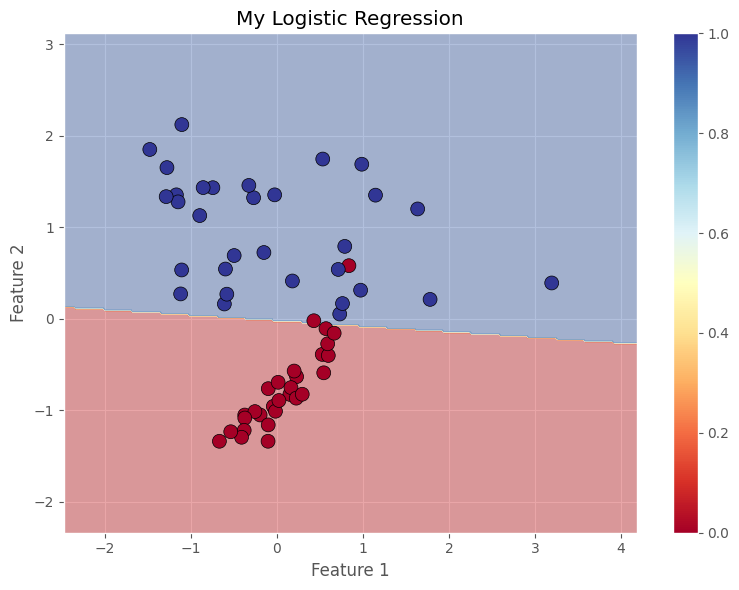

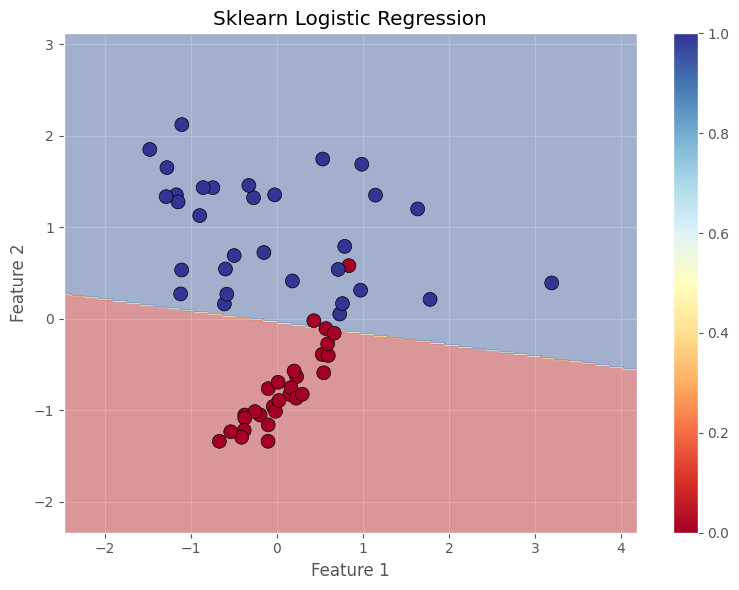

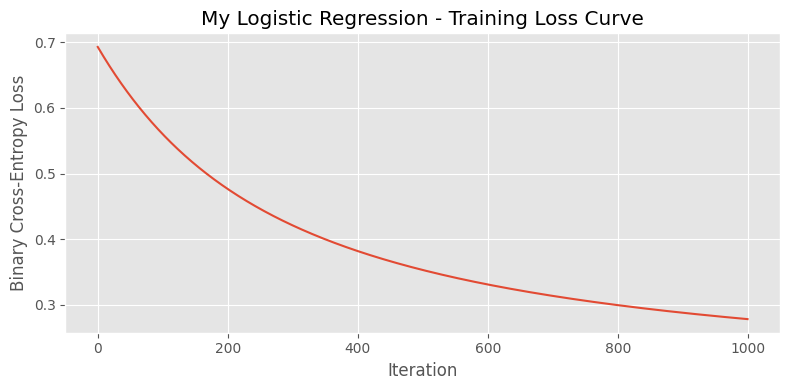

In [30]:
# Skeleton for TODO 8 (continued)
my_lr = SimpleLogisticRegression(learning_rate=0.01, num_iterations=1000)
my_lr.fit(X_train_, y_train_)

# Train sklearn's logistic regression
sk_lr = LogisticRegression(max_iter=1000)
sk_lr.fit(X_train_, y_train_)

# Compare accuracies
my_train_acc = accuracy_score(y_train, my_lr.predict(X_train))
my_test_acc = accuracy_score(y_test, my_lr.predict(X_test))

sk_train_acc = accuracy_score(y_train, sk_lr.predict(X_train))
sk_test_acc = accuracy_score(y_test, sk_lr.predict(X_test))

print("Model Comparison")
print("----------------------------------------")
print(f"My LR     Train: {my_train_acc:.4f} | Test: {my_test_acc:.4f}")
print(f"Sklearn LR Train: {sk_train_acc:.4f} | Test: {sk_test_acc:.4f}")


# Plot decision boundaries (for 2D data)
def plot_decision_boundary(X, y, model, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# plot_decision_boundary(X_test, y_test, my_lr, 'My Logistic Regression')
# Plot decision boundaries (ONLY if your X has 2 features)
plot_decision_boundary(X_test, y_test, my_lr, 'My Logistic Regression')
plot_decision_boundary(X_test, y_test, sk_lr, 'Sklearn Logistic Regression')

# Plot loss curve
plt.figure(figsize=(8, 4))
plt.plot(my_lr.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("My Logistic Regression - Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


# Answer: Why do we use the sigmoid function in logistic regression?
# ...

$$
z = w^T x + b
$$

Sigmoid converts it to probability:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

### Why sigmoid?

- Maps output to (0,1) so it represents probability:

$$
P(y=1 \mid x)
$$

- Differentiable → works with gradient descent

- Simple derivative:

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

- Works naturally with binary cross-entropy loss